In [1]:
import numpy.matlib
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import heatmap

from matplotlib import cm

In [2]:
j=complex(0,1)           # iota , sqrt of -1

n_side=26                # no. of atoms along an edge of the array

n=n_side**2              # for a square atomi array

c_light=3*10**8          # m/s speed of light

lamda=500 * 10**-9       # (in m) wavelength of light

w=2*np.pi*c_light/lamda

a=0.2*lamda              # interatomic distance, in terms of lamda

L=(n_side-1)*a           # length of the atomic array

k=2*np.pi/lamda          # wavenumber of incidnet light

epsilon=8.85*10**-12     # SI units, permitivitty of free space

#assuming no non-radiative losses and w_a=w
w_a=w 
lamda_a=c_light/(w_a/(2*np.pi))

alpha=3/(4*np.pi**2)*epsilon*lamda_a**3*j # polarization of an atom

#Charactersitics of incident beam: 

#polaization direction
e_x = np.array([1,0.,0.]) # the vector for x polarized field

#waist
w_0 = 0.3*np.sqrt(n)*a

#Amplitude of the electric field of the beam
E_beam_amp=1 # defaulted to 1 in the function below

In [3]:
def Greens(m,l,k,r_1,r_2):
    '''Calculates the greens function G_{ml}(r_1,r_2) using eq S3'''
    if ((r_1[0]==r_2[0])and(r_1[1]==r_2[1])and(r_1[2]==r_2[2])):    #skip the same atom
        return 0
    else:
        r_vect=r_1-r_2 
        r=np.sqrt(np.sum(np.square(r_vect)))
        
        if m==l: # serves as kronecker delta
            t1=(1+ (j*k*r-1)/((k*r)**2))
        else:
            t1=0
        t2=(-1 + (3-3*k*r*j)/(k*r)**2)*r_vect[m]*r_vect[l]/r**2
        t3=(np.cos(k*r)+j*np.sin(k*r))*(t1+t2)/(4*np.pi*r)  #eq S3
        return t3

$$G_{ij}(k,\textbf{r}_1,\textbf{r}_2)=\frac{e^{ikr}}{4\pi r}\left[\left(1+\frac{ikr-1}{k^2r^2}\right)\delta_{ij}+\left(-1+\frac{3-3ikr}{k^2r^2}\right)\frac{r^ir^j}{r^2}\right]$$
where $\textbf{r}=\textbf{r}_1-\textbf{r}_2$, $r=\left|{\textbf{r}}\right|$ and $r^i=e_i.\textbf{r}$

In [4]:
def gaussian_beam(x,y,z,w_0,lamda,e_L,E_0_amp=1):
    '''returns the incident gaussian beam at the point (x,y,z)\
    given byy equation eq. S55 \
    For z=0, exp(1/R(z)) term has been set to 0\
    lamda is the wavelength of the beam\
    w_0 is the beam waist at the focal point\
    e_L is the polarization vector\
    E_0_amp is the amplitude '''
    #wave number k
    k = 2*np.pi/lamda
    
    #below constants are as defined in the paper eq. S56
    z_R = np.pi*w_0**2/lamda 
    w_z = w_0*np.sqrt(1+(z/z_R)**2)

    phi_z = np.arctan(z/z_R)

    #Rz tends to infinity as z tends to 0. Which is why this ifelse condition is required \
    #to explicitly set the term involving  1/R to zero
    if z == 0:
        R_z = 1e100
        theta=k*z - phi_z #theta is the coeff of the exponential form of the complex number 
    else:
        R_z = z*(1+(z_R/z)**2)
        #This is the coeff of i in the exponential. 
        theta = k*z - phi_z + k*(x**2+y**2)/(2*R_z)
    
    #Following are the magnitude, real part and imaginary part respectively of the electric field of incident light
    E_0 = (E_0_amp*(w_0/w_z)*np.exp(-1*(x**2+y**2)/(w_z**2))*(np.cos(theta)+j*np.sin(theta)))*e_L # eq S55

    return E_0 #the final incident beam at (x,y,z) 

Gaussian beam equation:

$$\textbf{E}_0\left(x',y',z'\right) = E_0\textbf{e}_L\frac{w_0}{w(z')}e^{ikz'}e^{-i\phi(z')}e^{-\frac{x'^2+y'^2}{w^2(z')}}e^{ik\frac{x'^2+y'^2}{2R(z')}}$$
    
with the parameters being,
    
$$w(z)=w_0\sqrt{1+\left(\frac{z}{z_R}\right)^2},   z_R=\frac{\pi w_0^2}{\lambda},    R\left(z\right)=z\left[1+\left(\frac{z_R}{z}\right)^2\right],    \phi \left(z\right) = \arctan\left(\frac{z'}{z_R}\right)$$

Plot the variation of the electric field of the beam  with z axis at x=0,y=0

In [7]:
# Function which returns, incident, scattered and total electric field at position x, y, z
def E(x,y,z,E_at_atoms_V,R,lamda,w_0,alpha):   
    '''returns the incident electric field, scattered electric field and total electric field at the point (x,y,z)\
    E_at_atoms_V is the field at the atoms'''
    Greens_at_r = np.zeros(shape=(3,n,3),dtype=np.complex_)
    E_0_at_r = gaussian_beam(x,y,z,w_0,lamda,np.array([1,0,0]))# incident electric field
  
    for i in range(0,3):
        for m in range(0,3):
            for atoms_index in range(0,n):
                Greens_at_r[i,atoms_index,m]=Greens(i,m,k,(x,y,z),R[atoms_index])
                
    Greens_at_r_M = Greens_at_r.reshape(3,3*n)
    # the scattered electric field
    Scattered_field = (4*(np.pi**2)*alpha/(epsilon*lamda**2)) *np.matmul(Greens_at_r_M,E_at_atoms_V).reshape(3,)\
    #total electric field
    E_space = np.add(E_0_at_r , Scattered_field)
    
    return E_0_at_r, Scattered_field, E_space # incident field, scattered field, total field

finding transmittivity along a particular z direction

In [10]:
def transmittivity(R,w_0,alpha,wavelength,e_x,E_beam_amp,x_find=0,y_find=0,z_dist=100*lamda):     
#Field value at points where atoms are placed i.e. z=0
    E_0_at_atoms = np.zeros(shape=(n,3),dtype=np.complex_)

#position of atoms is at (x,y,0)

#The order is as explained in the final cell of gaussian_beam
    for i in range(0,n):
          E_0_at_atoms[i] = gaussian_beam(R[i][0],R[i][1],R[i][2],w_0,wavelength,e_x,E_beam_amp)
        
#E_0_at_atoms is a (n ,3) matrix, with n running over indices of atoms, 3 denoting the component of electric field at the atom
    G=np.empty(shape=(n,3,n,3),dtype=np.complex_)

#Calculating the G matrix to find the field at the atoms in n_1,3,n_2,3 form, where n_1 is index of r1, n_2 is index of r2
# this g is used in eq S54
    for r_1 in range(0,n):      
            for m in range(0,3):
                  for r_2 in range(0,n):
                        for l in range(0,3):
                            G[r_1,m,r_2,l]=Greens(m,l,k,R[r_1],R[r_2])# using eq S3
# G is in 3n * 3n matrix  form  
    G_M=G.reshape(3*n,3*n)

# E_0_at_atoms is the incident electric field at atoms
    E_0_V=E_0_at_atoms.reshape(3*n,1) # reshape E_n so that it can be multiplied by a 3n*3n  matrix

# Calculating total electric fields at the atoms
    I_M=np.identity(3*n,dtype=np.complex_)

    INVERSE_M=np.linalg.inv(I_M-(4*(np.pi**2)*alpha/(epsilon*wavelength**2)*G_M)) # the inverse term in eq S54

    E_at_atoms_V=np.matmul(INVERSE_M,E_0_V) # eq S54 

    E_at_atoms=E_at_atoms_V.reshape(n,3)    

    Incident_1,Scattered_1,Total_1=E(x_find,y_find,-z_dist,E_at_atoms_V,R,wavelength,w_0,alpha) # negative z
    Incident_2,Scattered_2,Total_2=E(x_find,y_find,z_dist,E_at_atoms_V,R,wavelength,w_0,alpha) # positive z

    T=abs(Total_2[0]/Incident_1[0])**2# transmittivity
    return T



    

In [40]:
limits_of_disorder=np.linspace(0,a,10)
Transmittivity=np.zeros(shape=len(limits_of_disorder) )
for i in range(0,len(limits_of_disorder)):
   
    R1=np.zeros(shape=(R.shape))
    disorder=np.random.uniform(low=0,high=limits_of_disorder[i],size=(n,))
    R1[:,0]=disorder+R[:,0]
# for disorder in y
    disorder=np.random.uniform(low=0,high=limits_of_disorder[i],size=(n,))
    R1[:,1]=disorder+R[:,1]
    Transmittivity[i]=transmittivity(R1,w_0,alpha,lamda,e_x,E_beam_amp,x_find=0,y_find=0,z_dist=100*lamda)
    print(i)


0
1
2
3
4
5
6
7
8
9


Text(0.5, 0, 'Maximum disorder (in units of a)')

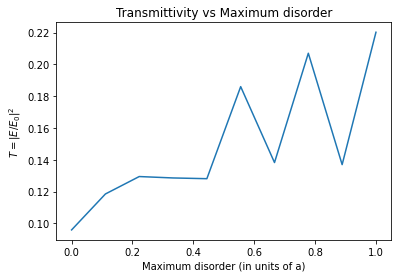

In [46]:
plt.plot(limits_of_disorder/a,Transmittivity)
plt.title('Transmittivity vs Maximum disorder')
plt.ylabel(r'$T=|E/E_{0}|^2$')
plt.xlabel('Maximum disorder (in units of a)')


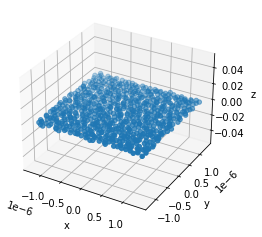

In [21]:
R=np.zeros(shape=(n,3)) 
for i in range(0,n):
    R[i]=((-L/2+a*(i%n_side)),(L/2-a*int((i/n_side))),0)
# for disorder in x
disorder=np.random.uniform(low=0,high=a,size=(n,))
R[:,0]=disorder+R[:,0]
# for disorder in y
disorder=np.random.uniform(low=0,high=a,size=(n,))
R[:,1]=disorder+R[:,1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(3*10**-7,2*10**-7,'x')
ax.scatter3D(R[:,0],R[:,1],R[:,2],cmap="Greens")

[0 1 0 0]
